# Übung 4
## Generalized Hough Transform
### R-Table
Implementiere die Erstellung des R-Tables, wie in der Vorlesung beschrieben. Erstelle Dir ein Template aus dem Bild "animals.png", indem Du einen Bildbereich extrahierst (siehe Code unten) und dieses ROI mit Sobel und Canny weiterverarbeitest, um die Gradientenrichtungen und Kantensegmentierung zu erhalten. Erstelle nun das R-Table für Dein Template und zeichne als "Sanity Check" alle Zentrumsvektoren als Punkte, deren Farbe die Gradientenrichtung wiederspiegelt (am einfachsten einen Grauwertpixel setzen und die Colormap anpassen!).

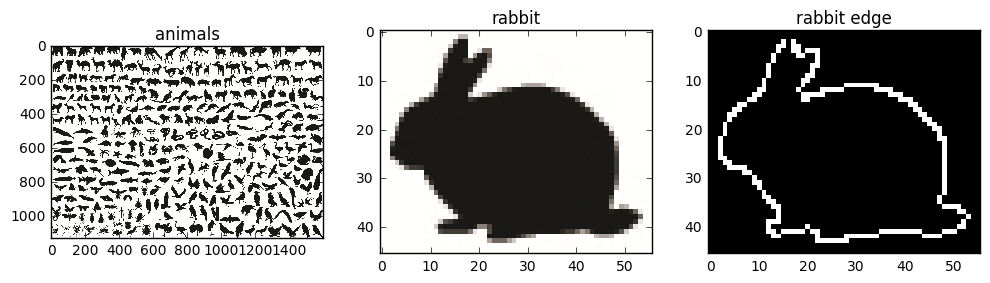

In [93]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color, filters
import numpy as np
from scipy import ndimage
import warnings
warnings.filterwarnings("ignore")

animals = io.imread('images/animals.png')

xmin = 1327
xmax = 1383
ymin = 259
ymax = 305

rabbit = animals[ymin:ymax, xmin:xmax]
rabbit_grayNsmooth = filters.gaussian(color.rgb2gray(rabbit), 1)

sobel_X = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
sobel_Y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
g_X = ndimage.convolve(rabbit_grayNsmooth, sobel_X)
g_Y = ndimage.convolve(rabbit_grayNsmooth, sobel_Y)
# Matrix fuer Gradientenrichtung:
rabbit_deg = np.arctan2(g_Y,g_X) * 180 / np.pi
rabbit_deg_pos = rabbit_deg + (rabbit_deg < 0)*180
# Matrix mit Kantensegmentierung:
rabbit_edge = feature.canny(rabbit_grayNsmooth, 0)

fig = plt.figure(figsize=(10, 5))
a=fig.add_subplot(131)
imgplot = io.imshow(animals)
a.set_title('animals')
b=fig.add_subplot(132)
imgplot = io.imshow(rabbit)
b.set_title('rabbit')
c=fig.add_subplot(133)
imgplot = io.imshow(rabbit_edge)
c.set_title('rabbit edge') 

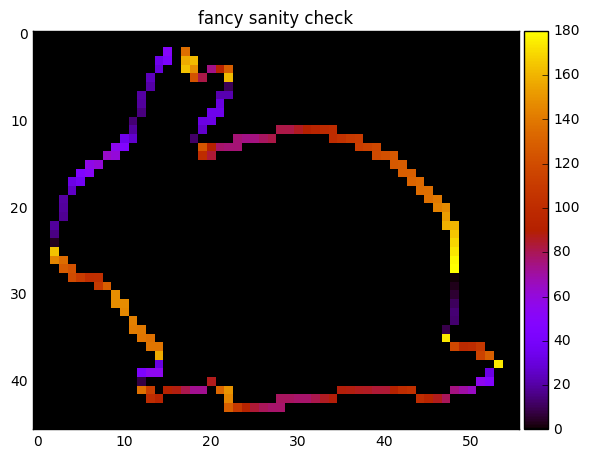

In [94]:
# compute reference-point
(n, m) = rabbit_edge.shape
x_c = int(m/2)
y_c = int(n/2)

# fill r-table
r_table = {}
for y in range(n):
    for x in range(m):
        if rabbit_edge[y, x]:
            gradient = int(round(rabbit_deg_pos[y, x], 0))
            v = [(x_c - x, y_c - y)]
            if gradient in r_table:
                r_table[gradient] = r_table[gradient] + v
            else:
                r_table[gradient] = v

# sanity check
gradient_pic = np.zeros((n, m))
for gradient, vector_list in r_table.items():
    for point in vector_list:
        x = x_c - point[0]
        y = y_c - point[1]
        gradient_pic[y, x] = gradient

fig = plt.figure(figsize=(6, 6))
a=fig.add_subplot(111)
imgplot = io.imshow(gradient_pic, cmap = 'gnuplot')
a.set_title('fancy sanity check')            

### Akkumulator
Jetzt implementiere das Füllen des Akkumulators für ein gegebenes Suchbild, das in Form von zwei Matrizen übergeben wird:  Gradientenrichtungs- (Sobel) und Kantenbild (Canny). Natürlich könnt ihr auch Eure eigenen Implementierungen dafür nehmen ;)
Nimm nun das R-Table Deines Templates von oben und zeige den Akkumulator (als Bild) für folgenes Testszenario: 
- erstelle ein leeres Kantenbild und setze einen beliebigen Pixel auf 1
- setzte die korrespondierende Kantenrichtung auf einen beliebigen Richtungswert
- variiere diese Gradientenrichtung und zeige den Effekt im Akkumulator
- nimm nun das komplette Suchbild "animals.png" und zeige den Akkumulator

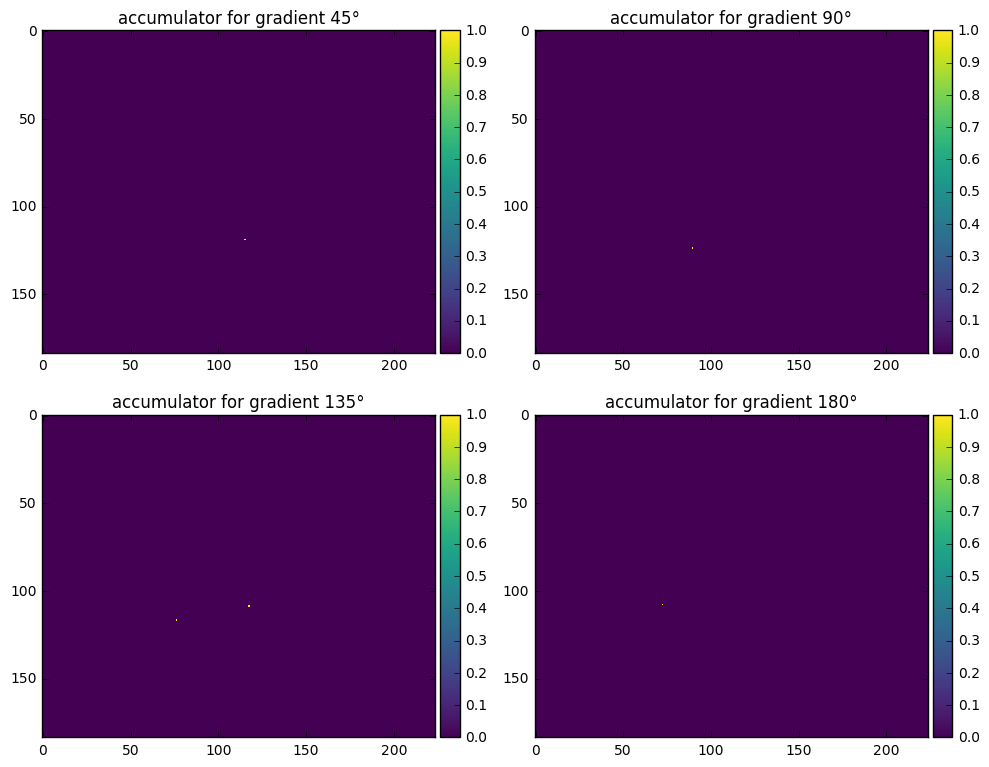

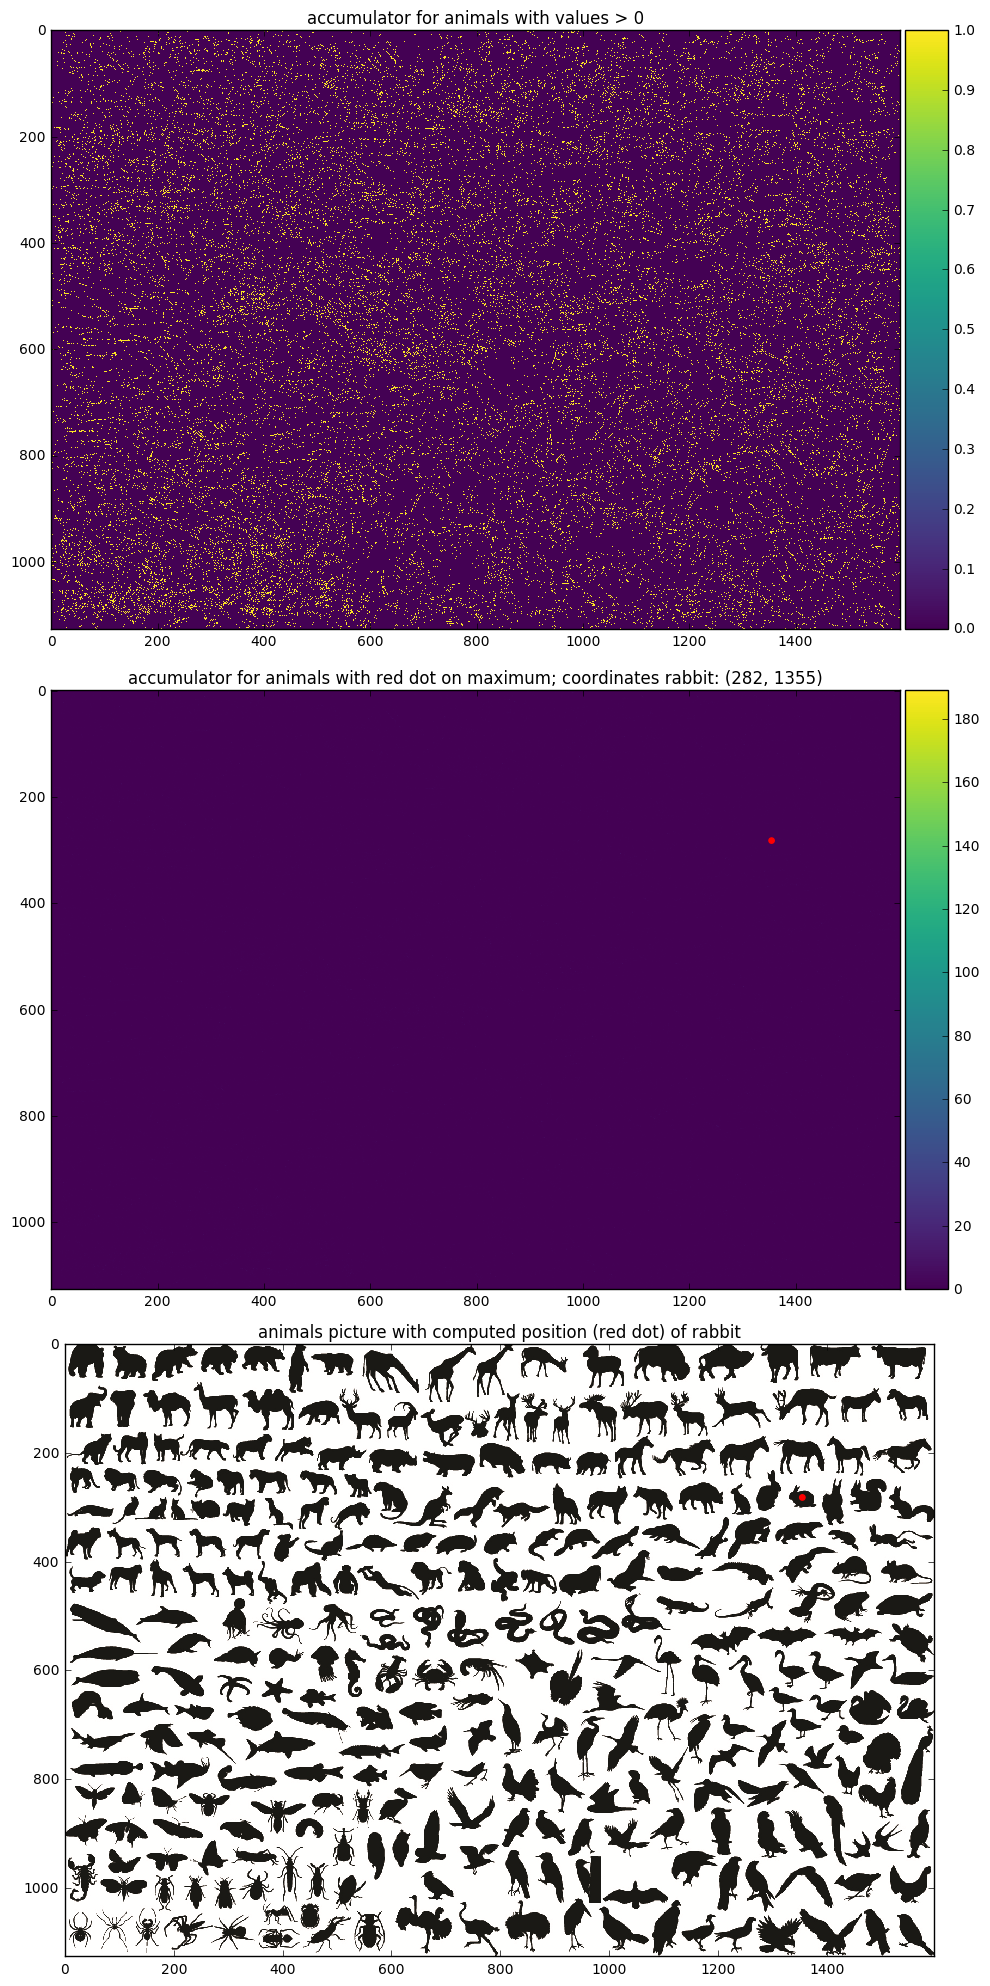

In [95]:
from matplotlib.patches import Circle

def pic2sobanny(image):
    image_grayNsmooth = filters.gaussian(color.rgb2gray(image), 1)
    g_X = ndimage.convolve(image_grayNsmooth, sobel_X)
    g_Y = ndimage.convolve(image_grayNsmooth, sobel_Y)
    image_deg = np.arctan2(g_Y,g_X) * 180 / np.pi
    sobel = image_deg + (image_deg < 0)*180
    canny = feature.canny(image_grayNsmooth, 0)
    return((sobel, canny))

def ind2coord(ind, m):
    return(int(ind/m), ind%m)

def accumulate(sobel, canny, r_table):
    (n, m) = canny.shape
    acc = np.zeros((n, m))
    for y in range(n):
        for x in range(m):
            if canny[y, x]:
                gradient = int(round(sobel[y, x], 0))
                if gradient in r_table:
                    for vector in r_table[gradient]:
                        x_v = vector[0]
                        y_v = vector[1]
                        x_c = x + x_v
                        y_c = y + y_v
                        if ((x_c >= 0 and x_c < m) 
                            and (y_c >= 0 and y_c < n)):
                            acc[y_c, x_c] = acc[y_c, x_c] + 1
    return(acc)

# -------------------------------------------------------------
# 1-Pixel-Suchbild

g = 2
h = 2*g
x_p = g*n
y_p = g*m
w1 = 45
w2 = 90
w3 = 135
w4 = 180
canny_test = np.zeros((h*n, h*m))
sobel_test = np.zeros((h*n, h*m))
canny_test[y_p, x_p] = 1

fig = plt.figure(figsize=(10, 8))
a=fig.add_subplot(221)
sobel_test[y_p, x_p] = w1
imgplot = io.imshow(accumulate(sobel_test, canny_test, r_table))
a.set_title("accumulator for gradient "+str(w1)+"°")

b=fig.add_subplot(222)
sobel_test[y_p, x_p] = w2
imgplot = io.imshow(accumulate(sobel_test, canny_test, r_table))
b.set_title("accumulator for gradient "+str(w2)+"°")

c=fig.add_subplot(223)
sobel_test[y_p, x_p] = w3
imgplot = io.imshow(accumulate(sobel_test, canny_test, r_table))
c.set_title("accumulator for gradient "+str(w3)+"°")

d=fig.add_subplot(224)
sobel_test[y_p, x_p] = w4
imgplot = io.imshow(accumulate(sobel_test, canny_test, r_table))
d.set_title("accumulator for gradient "+str(w4)+"°")
plt.show()

# -------------------------------------------------------------
# Animal-Suchbild

(sobel_animals, canny_animals) = pic2sobanny(animals)
animal_acc = accumulate(sobel_animals, canny_animals, r_table)
pos_coord = ind2coord(np.argmax(animal_acc), animal_acc.shape[1])

fig = plt.figure(figsize=(10, 20))
a=fig.add_subplot(311)
imgplot = io.imshow((animal_acc > 0)*1)
a.set_title('accumulator for animals with values > 0')

b=fig.add_subplot(312)
imgplot = io.imshow(animal_acc)
circ = Circle((pos_coord[1], pos_coord[0]), 5, color='red')
b.add_patch(circ)
b.set_title('accumulator for animals with red dot on maximum;'
            +' coordinates rabbit: '+str(pos_coord))
c=fig.add_subplot(313)
imgplot = io.imshow(animals)
circ = Circle((pos_coord[1], pos_coord[0]), 5, color='red')
c.add_patch(circ)
c.set_title('animals picture with computed position (red dot) of rabbit')
plt.show()